In [1]:
!pip install pandas pyspellchecker sentence-transformers faiss-cpu numpy scikit-learn gensim nltk matplotlib

import nltk
nltk.download('all')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 870.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [9]:
import os
import pandas as pd
import re
import numpy as np
import faiss
from spellchecker import SpellChecker
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import json

In [10]:
# -------------------------------------------
# Step 1: Data Preprocessing
# - Reads raw data from a CSV file (column "query")
# - Cleans the text (lowercase and remove non-alphanumeric characters)
# - Spell-corrects each query using pyspellchecker
# - Saves the preprocessed data to a CSV file to cache results
# -------------------------------------------
def clean_text(text: str) -> str:
    """Convert text to lowercase and remove non-alphanumeric characters."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def correct_text(text: str, spell: SpellChecker) -> str:
    """
    Spell-correct each word in the text.
    If no correction is found, use the original word.
    """
    corrected_words = []
    for word in text.split():
        corrected = spell.correction(word)
        corrected_words.append(corrected if corrected is not None else word)
    return " ".join(corrected_words)

def preprocess_data_from_csv(input_csv: str, output_csv: str) -> pd.DataFrame:
    """
    Load raw data from CSV, preprocess queries (clean & spell-correct),
    and save the resulting DataFrame to CSV.
    """
    df = pd.read_csv(input_csv)
    spell = SpellChecker()
    df['clean_query'] = df['query'].apply(lambda x: clean_text(str(x)))
    df['corrected_query'] = df['clean_query'].apply(lambda x: correct_text(x, spell))
    df.to_csv(output_csv, index=False)
    print(f"Preprocessed data saved to {output_csv}")
    return df

In [11]:
# -------------------------------------------
# Step 2: Compute Embeddings & Build FAISS Index
# - Uses SentenceTransformer to encode the corrected queries into embeddings.
# - Saves embeddings as a numpy file.
# - Builds a FAISS index for fast similarity search and saves it.
# -------------------------------------------
def build_faiss_index(df: pd.DataFrame, embeddings_file: str, index_file: str):
    """
    Generate embeddings for corrected queries and build a FAISS index.
    Both the embeddings and the index are saved to disk.
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')
    queries = df['corrected_query'].tolist()
    embeddings = model.encode(queries, show_progress_bar=True)
    embeddings = np.array(embeddings).astype('float32')
    np.save(embeddings_file, embeddings)
    print(f"Embeddings saved to {embeddings_file}")

    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    faiss.write_index(index, index_file)
    print(f"FAISS index built and saved to {index_file}")
    return embeddings, index

In [12]:
# -------------------------------------------
# Step 3: Cluster Queries Using KMeans
# - Clusters the embeddings into a specified number of clusters.
# - Saves the DataFrame (with added cluster labels) to CSV.
# -------------------------------------------
def cluster_queries(df: pd.DataFrame, embeddings: np.ndarray, num_clusters: int, output_csv: str) -> pd.DataFrame:
    """
    Cluster queries based on their embeddings using KMeans.
    The cluster labels are added to the DataFrame and saved.
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    df['cluster'] = clusters
    df.to_csv(output_csv, index=False)
    print(f"Clustered data saved to {output_csv}")
    return df

In [31]:
# -------------------------------------------
# Step 4: Topic Modeling for Each Cluster
# - For each cluster, tokenizes corrected queries and builds a corpus.
# - Uses gensim's LDA to extract topics.
# - Saves the topic modeling results to a JSON file.
# -------------------------------------------
def perform_topic_modeling(df: pd.DataFrame, num_topics: int = 1, num_words: int = 3) -> dict:
    """
    Perform topic modeling on each cluster using LDA.
    Returns a dictionary of topics per cluster with keys as standard Python ints.
    """
    cluster_topics = {}
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        documents = cluster_data['corrected_query'].tolist()

        # Tokenize documents
        tokenized_docs = [word_tokenize(str(doc)) for doc in documents]
        dictionary = corpora.Dictionary(tokenized_docs)
        corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

        # If no tokens are available, record an empty topic list for the cluster
        if len(dictionary) == 0:
            cluster_topics[int(cluster)] = []
            continue

        lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        topics = lda_model.print_topics(num_words=num_words)
        cluster_topics[int(cluster)] = topics
    return cluster_topics

def save_topics(topics: dict, topics_file: str):
    """
    Save the topics dictionary to a JSON file.
    """
    with open(topics_file, 'w') as f:
        json.dump(topics, f, indent=4)
    print(f"Topic modeling results saved to {topics_file}")

def load_topics(topics_file: str, df: pd.DataFrame, num_topics=1, num_words=3) -> dict:
    """
    Attempt to load topics from a JSON file.
    If the file is invalid, re-run topic modeling and save a new file.
    """
    try:
        with open(topics_file, 'r') as f:
            topics = json.load(f)
        print("Topics loaded from file.")
    except json.JSONDecodeError:
        print("Invalid JSON in topics file. Recomputing topics...")
        topics = perform_topic_modeling(df, num_topics=num_topics, num_words=num_words)
        save_topics(topics, topics_file)
    return topics


In [33]:
# -------------------------------------------
# Step 5: Generate Insights & Visualizations
# - Flags queries where the original text differs from the corrected text.
# - Computes spelling error percentages per cluster.
# - Plots a bar chart of query counts per cluster.
# - Prints sample queries for each cluster.
# -------------------------------------------
def generate_insights(df: pd.DataFrame):
    """
    Compare original and corrected queries to flag spelling errors,
    summarize error rates per cluster, and visualize query distribution.
    """
    # Ensure the values are strings before stripping and lowering
    df['spelling_error'] = df.apply(
        lambda row: str(row['query']).strip().lower() != str(row['corrected_query']).strip().lower(), axis=1
    )

    # Group by cluster and compute total queries and count of spelling errors
    cluster_summary = df.groupby('cluster').agg({
        'query': 'count',
        'spelling_error': 'sum'
    }).rename(columns={'query': 'total_queries', 'spelling_error': 'num_spelling_errors'})

    # Calculate the percentage of queries with spelling errors per cluster
    cluster_summary['spelling_error_percentage'] = (
        cluster_summary['num_spelling_errors'] / cluster_summary['total_queries'] * 100
    )

    print("Cluster-level summary:")
    print(cluster_summary)

    # Interpret and print insights for each cluster based on the spelling error rate
    for cluster, row in cluster_summary.iterrows():
        if row['spelling_error_percentage'] > 50:
            print(f"\nCluster {cluster} is dominated by spelling errors "
                  f"({row['spelling_error_percentage']:.1f}% of queries required corrections). "
                  "This likely indicates failures due to product spelling mistakes.")
        else:
            print(f"\nCluster {cluster} has a lower spelling error rate "
                  f"({row['spelling_error_percentage']:.1f}%). "
                  "Failures in this cluster might be due to wrong category type or product not available.")

    # Plot the distribution of queries across clusters
    plt.figure(figsize=(8, 6))
    cluster_summary['total_queries'].plot(kind='bar')
    plt.xlabel("Cluster")
    plt.ylabel("Number of Queries")
    plt.title("Distribution of Queries Across Clusters")
    plt.savefig("cluster_distribution.png")
    plt.show()
    print("Cluster distribution plot saved as cluster_distribution.png")

    # Display sample queries (original vs. corrected) for manual review per cluster
    for cluster in sorted(df['cluster'].unique()):
        print(f"\nCluster {cluster} sample queries (original vs. corrected):")
        print(df[df['cluster'] == cluster][['query', 'corrected_query']].head(5).to_string(index=False))



Loading preprocessed data from preprocessed_data.csv...
Loading embeddings and FAISS index from files...
Clustering queries...
Clustered data saved to clustered_data.csv
Performing topic modeling for each cluster...
Topic modeling results saved to topics.json
Cluster-level summary:
         total_queries  num_spelling_errors  spelling_error_percentage
cluster                                                               
0                  251                   96                  38.247012
1                 1419                  849                  59.830867
2                  188                   68                  36.170213
3                  855                  649                  75.906433
4                  286                  120                  41.958042

Cluster 0 has a lower spelling error rate (38.2%). Failures in this cluster might be due to wrong category type or product not available.

Cluster 1 is dominated by spelling errors (59.8% of queries required corrections

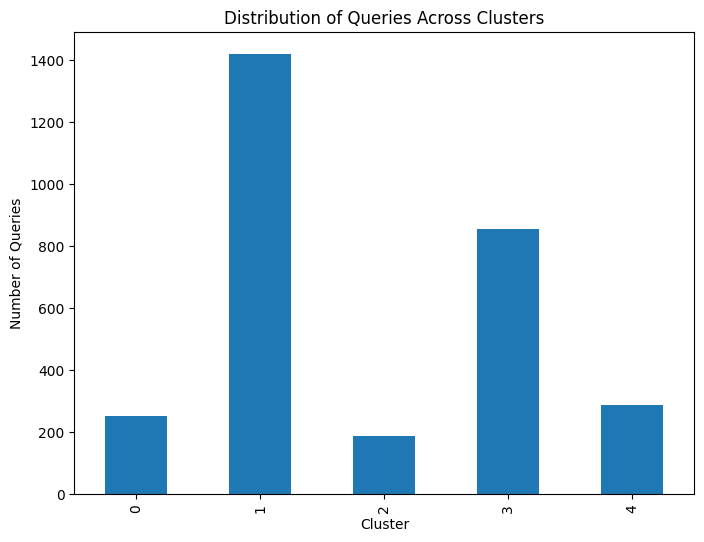

Cluster distribution plot saved as cluster_distribution.png

Cluster 0 sample queries (original vs. corrected):
                 query       corrected_query
       ladies flipflop       ladies slipslop
          fx foot wear         fix foot wear
         Chalsia Boots         chelsea boots
          TFC footwear          tic footwear
kain footwear  factory kain footwear factory

Cluster 1 sample queries (original vs. corrected):
           query  corrected_query
best quality man best quality man
          winger           winger
           samba            samba
          bridal           bridal
          khitan           khotan

Cluster 2 sample queries (original vs. corrected):
        query corrected_query
riding jacket   riding jacket
       jacket          jacket
  t shirts ck     t shirts ok
   shirt pant      shirt pant
jauket man bo   jacket man to

Cluster 3 sample queries (original vs. corrected):
 query corrected_query
chupps          chumps
 abros            bros
 abros   

In [34]:
# -------------------------------------------
# Main Pipeline
# -------------------------------------------
def main():
    # Define file paths (modify these as needed)
    input_csv = "failed_search_queries.csv"           # CSV file with raw data; must contain a column named "query"
    preprocessed_csv = "preprocessed_data.csv"
    clustered_csv = "clustered_data.csv"
    embeddings_file = "embeddings.npy"
    faiss_index_file = "faiss_index.index"
    topics_file = "topics.json"

    # Step 1: Preprocess the data
    if not os.path.exists(preprocessed_csv):
        print("Preprocessing data from CSV...")
        df = preprocess_data_from_csv(input_csv, preprocessed_csv)
    else:
        print(f"Loading preprocessed data from {preprocessed_csv}...")
        df = pd.read_csv(preprocessed_csv)

    # Step 2: Compute embeddings and build FAISS index
    if not os.path.exists(embeddings_file) or not os.path.exists(faiss_index_file):
        print("Building FAISS index from embeddings...")
        embeddings, index = build_faiss_index(df, embeddings_file, faiss_index_file)
    else:
        print("Loading embeddings and FAISS index from files...")
        embeddings = np.load(embeddings_file)
        index = faiss.read_index(faiss_index_file)

    # Step 3: Cluster queries
    if 'cluster' not in df.columns or df['cluster'].isnull().all():
        print("Clustering queries...")
        df = cluster_queries(df, embeddings, num_clusters=5, output_csv=clustered_csv)
    else:
        print("Cluster information already available in preprocessed data.")

    # Step 4: Perform topic modeling
    if not os.path.exists(topics_file):
      print("Performing topic modeling for each cluster...")
      topics = perform_topic_modeling(df, num_topics=1, num_words=3)
      save_topics(topics, topics_file)
    else:
      print(f"Loading topics from {topics_file}...")
      with open(topics_file, 'r') as f:
        topics = json.load(f)
      print(topics)

    # Step 5: Generate insights and visualization
    generate_insights(df)

if __name__ == "__main__":
    main()